In [15]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import timm
import torch
from albumentations import (
    Compose,
    Normalize,
    ShiftScaleRotate,
    RandomBrightnessContrast,
    MotionBlur,
    CLAHE,
    HorizontalFlip
)
from copy import deepcopy
from torch.utils.data import Dataset
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score, accuracy_score

In [16]:
# from google.colab import drive
# drive.mount('/content/drive')

In [17]:
# %cd drive/MyDrive/'BIOMEDIN220-F2022'/

In [18]:
dataset_path = "vinbigdata-chest-xray-resized-png-256x256"
model_path = "vinbigdata-chest-xray-resized-png-256x256/save_models"

train_csv_path = os.path.join(dataset_path, 'vindrcxr_train.csv')
test_csv_path = os.path.join(dataset_path, 'vindrcxr_test.csv')
train_image_path = os.path.join(dataset_path, 'train')
test_image_path = os.path.join(dataset_path, 'test')
save_path = os.path.join(model_path, '')

print(train_image_path)
print(test_image_path)

vinbigdata-chest-xray-resized-png-256x256/train
vinbigdata-chest-xray-resized-png-256x256/test


In [19]:
!ls vinbigdata-chest-xray-resized-png-256x256

save_models  train	     vinbigdata-chest-xray-resized-png-256x256.zip
test	     train.csv	     vindrcxr_test.csv
test.csv     train_meta.csv  vindrcxr_train.csv


In [20]:
### Code from https://github.com/Scu-sen/VinBigData-Chest-X-ray-Abnormalities-Detection

class Dataset(Dataset):
    
    def __init__(self, df, image_path, transform=None):
        self.df = df
        self.image_path = image_path
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        labels = torch.from_numpy(
            self.df.loc[idx,np.arange(0,15).astype(str).tolist()].values.astype(float)
        ).float()

        img = cv2.imread(
            self.image_path + '/' + str(self.df.image_id[idx]) + '.png'
        )
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            img = self.transform(image=img)['image']
        img = torch.from_numpy(img.transpose((2, 0, 1))).float()
            
        return img, labels

In [21]:
bs = 2
lr = 1e-3
N_EPOCHS = 10

In [22]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

In [23]:
def train_model(model, data_loader, optimizer, criterion): # train 1 epoch
    """
    Trains the model for 1 epoch
    
    Parameters:
        model (torch.nn.Module): The model to be trained/validated.
        data_loader (torch.utils.data.DataLoader): Dataloader object for training/validation.
        optimizer (A torch.optim class): The optimizer.
        criterion (A function in torch.nn.modules.loss): The loss function. 
        
    Return: 
        avg_loss (float): The average loss.
    """
    
    model.train()
    
    running_loss = 0.0
    running_n = 0
    avg_loss = 0.0
    preds_list, targets_list = [], []

    optimizer.zero_grad()
    
    tk = tqdm(data_loader, total=len(data_loader), position=0, leave=True)
    for idx, (imgs, labels) in enumerate(tk):
        imgs, labels = imgs.cuda(), labels.cuda()
        output = model(imgs)
        
        loss = criterion(output, labels) 
        
        loss.backward()
        optimizer.step() 
        optimizer.zero_grad() 
        
        running_loss += loss.item() * imgs.size(0)
        running_n += imgs.size(0)
        tk.set_postfix(loss=running_loss / running_n)

        preds = torch.sigmoid(output).detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
      
        preds_list.append(preds)
        targets_list.append(labels.round().astype(int))
    print(running_n, len(data_loader))
    avg_loss = running_loss / running_n

    preds_list = np.concatenate(preds_list,axis=0).T
    targets_list = np.concatenate(targets_list,axis=0).T
    
    aucs = np.array(
        [roc_auc_score(i,j) if len(set(i))>1 else np.nan for i,j in zip(targets_list, preds_list)]
    )
    overall_auc = np.nanmean(aucs)

    thresholded_preds_list = np.round(preds_list)
    accs = np.array(
        [accuracy_score(i,j) if len(set(i))>1 else np.nan for i,j in zip(targets_list, thresholded_preds_list)]
    )
    overall_acc = np.nanmean(accs)

    return avg_loss, aucs, overall_auc, accs, overall_acc

In [ ]:
def val_model(model, data_loader, criterion):
    """
    Test the model on the validation set
    
    Parameters:
        model (torch.nn.Module): The model to be trained/validated.
        data_loader (torch.utils.data.DataLoader): Dataloader object for training/validation.
        optimizer (A torch.optim class): The optimizer.
        criterion (A torch.nn.modules.loss class): The loss function. 
        
    Return: 
        avg_loss (float): The average loss.
    """
    model.eval()
    
    running_loss = 0.0
    running_n = 0
    avg_loss = 0.0
    preds_list, targets_list = [], []
    
    with torch.no_grad():
        tk = tqdm(data_loader, total=len(data_loader), position=0, leave=True)
        
        for idx, (imgs, labels) in enumerate(tk):  
            imgs, labels = imgs.cuda(), labels.cuda()
            output = model(imgs)
            
            loss = criterion(output, labels)
            running_loss += loss.item() * imgs.size(0)
            running_n += imgs.size(0)
            tk.set_postfix(loss=running_loss / running_n)
            
            preds = torch.sigmoid(output).detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
         
            preds_list.append(preds)
            targets_list.append(labels.round().astype(int))
        print(running_n, len(data_loader))
        avg_loss = running_loss / running_n

        preds_list = np.concatenate(preds_list,axis=0).T
        targets_list = np.concatenate(targets_list,axis=0).T
        
        aucs = np.array(
            [roc_auc_score(i,j) if len(set(i))>1 else np.nan for i,j in zip(targets_list, preds_list)]
        )
        overall_auc = np.nanmean(aucs)

        thresholded_preds_list = np.round(preds_list)
        accs = np.array(
            [accuracy_score(i,j) if len(set(i))>1 else np.nan for i,j in zip(targets_list, thresholded_preds_list)]
        )
        overall_acc = np.nanmean(accs)
        
    return avg_loss, aucs, overall_auc, accs, overall_acc

In [25]:
def main():
    seed_everything(42)

    train = pd.read_csv(train_csv_path)
    test = pd.read_csv(test_csv_path)

    train_transform = Compose([
        HorizontalFlip(p=0.5),
        ShiftScaleRotate(scale_limit = 0.15, rotate_limit = 10, p = 0.5),
        RandomBrightnessContrast(p=0.5),
        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)
    ])
    test_transform = Compose([
        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)
    ])

    trainset = Dataset(
        train,
        image_path=train_image_path,
        transform=train_transform
    )
    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=bs, num_workers=1,
        shuffle=True 
    )

    valset = Dataset(
        test,
        image_path=test_image_path,
        transform=test_transform
    )
    val_loader = torch.utils.data.DataLoader(
        valset, batch_size=bs, shuffle=False, num_workers=1
    )

    model = timm.create_model('tf_efficientnet_b4_ns',pretrained=True,num_classes=15).cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    criterion = torch.nn.BCEWithLogitsLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=0.1, mode='max')

    best_weights = deepcopy(model.state_dict())
    previous_lr = lr
    best_auc = 0
    best_aucs = [0]*15
    best_val_loss = 100
    es = 0

    train_loss_history, val_loss_history = [], []
    acc_train_history, acc_val_history = [], []
    for epoch in range(N_EPOCHS):
        avg_train_loss, aucs_train, auc_train, accs_train, acc_train = train_model(model, train_loader, optimizer, criterion)
        avg_val_loss, aucs_val, auc_val, accs_val, acc_val = val_model(model, val_loader, criterion)

        train_loss_history.append(avg_train_loss)
        val_loss_history.append(avg_val_loss)
        acc_train_history.append(acc_train)
        acc_val_history.append(acc_val)

        print('epoch:', epoch)
        print("Training Metrics")
        print('lr:', previous_lr, 'train_loss:', avg_train_loss, 'weighted avg auc:',auc_train, 'weighted avg acc:', acc_train)
        print('aucs:',aucs_train)
        print('accs:', accs_train)
        print("Validation Metrics")
        print('lr:', previous_lr, 'val_loss:',avg_val_loss, 'weighted avg auc:',auc_val, 'weighted avg acc:', acc_val)
        print('aucs:',aucs_val)
        print('accs:', accs_val)

        # Record the best weights if either of AUC or val_loss improved.
        if auc_val > best_auc or avg_val_loss < best_val_loss:
            print('saving best weight...')
            best_weights = deepcopy(model.state_dict())
            for k,v in best_weights.items():
                best_weights[k] = v.cpu()

        # Save the model weight if the AUC of any class is improved. 
        for i in range(len(best_aucs)):
            if aucs_val[i] > best_aucs[i]:
                best_aucs[i] = aucs_val[i]
                d = {'weight':model.state_dict(), 'auc':aucs_val[i], 'epoch':epoch}
                torch.save(d, save_path + f'multilabel_efnb4_v1_cls{i}.pth')

        # Update best avg_val_loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss

        # Update best weighted../../results/multilabel_cls/v2/ AUC and implement early stop
        if auc_val > best_auc:
            es = 0
            best_auc = auc_val
        else:
            es += 1
            if es > 10:
                break

        scheduler.step(auc_val)
    print(train_loss_history)
    print(val_loss_history)

    plt.plot(range(N_EPOCHS), train_loss_history, label='Training Loss')
    plt.plot(range(N_EPOCHS), val_loss_history, label='Validation Loss')

    # Add in a title and axes labels
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig(save_path + f'multilabel_efnb4_v1_loss_history.png')
    plt.show()

In [26]:
!nvidia-smi

Tue Dec  6 06:34:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    33W /  70W |   3720MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

  0%|          | 0/7500 [00:00<?, ?it/s]

15000 7500


  0%|          | 0/1500 [00:00<?, ?it/s]

3000 1500
epoch: 0
Training Metrics
lr: 0.001 train_loss: 0.18043110528712472 weighted avg auc: 0.7260837853647407 weighted avg acc: 0.9437111111111111
aucs: [0.79088733 0.69854107 0.64785524 0.80491409 0.74950496 0.68106683
 0.72846119 0.75840634 0.66173173 0.72259139 0.7641829  0.73468793
 0.63213737 0.71302971 0.80325869]
accs: [0.85446667 0.9916     0.98106667 0.8816     0.99046667 0.98133333
 0.98206667 0.9546     0.97126667 0.97386667 0.95333333 0.94
 0.99173333 0.92713333 0.78113333]
Validation Metrics
lr: 0.001 val_loss: 0.2120949574370558 weighted avg auc: 0.7815185410977358 weighted avg acc: 0.9268222222222222
aucs: [0.84179039 0.72265806 0.72998766 0.88027333 0.73328455 0.78179103
 0.78924729 0.77595695 0.70340265 0.78880453 0.83593562 0.78143504
 0.74463447 0.76579662 0.84777993]
accs: [0.83533333 0.97133333 0.93533333 0.88666667 0.96766667 0.92633333
 0.97966667 0.96       0.941      0.96466667 0.91933333 0.922
 0.994      0.91333333 0.78566667]
saving best weight...


  0%|          | 0/7500 [00:00<?, ?it/s]

15000 7500


  0%|          | 0/1500 [00:00<?, ?it/s]

3000 1500
epoch: 1
Training Metrics
lr: 0.001 train_loss: 0.13834861131304255 weighted avg auc: 0.8546642864143149 weighted avg acc: 0.9568844444444444
aucs: [0.91619281 0.85708671 0.77604166 0.91655685 0.8739357  0.82834278
 0.83458392 0.86585833 0.79303097 0.82091019 0.88985659 0.84287881
 0.84410295 0.83160705 0.92897898]
accs: [0.88253333 0.99586667 0.9882     0.90246667 0.99193333 0.98986667
 0.98353333 0.963      0.97266667 0.9758     0.95853333 0.94053333
 0.99613333 0.93246667 0.87973333]
Validation Metrics
lr: 0.001 val_loss: 0.18554785304858037 weighted avg auc: 0.8200433174921596 weighted avg acc: 0.9367111111111109
aucs: [0.86215173 0.78782462 0.77806211 0.8950956  0.81500373 0.84504827
 0.81727771 0.806715   0.7259408  0.80828733 0.88031645 0.81318831
 0.8054624  0.79472141 0.86555429]
accs: [0.89766667 0.97133333 0.935      0.906      0.96566667 0.92533333
 0.975      0.94533333 0.94       0.96366667 0.95033333 0.93
 0.994      0.92666667 0.82466667]
saving best weight...

  0%|          | 0/7500 [00:00<?, ?it/s]

15000 7500


  0%|          | 0/1500 [00:00<?, ?it/s]

3000 1500
epoch: 2
Training Metrics
lr: 0.001 train_loss: 0.12192436509355903 weighted avg auc: 0.8920577903453573 weighted avg acc: 0.9621022222222222
aucs: [0.94486538 0.88538108 0.82805085 0.94566963 0.90646143 0.86531324
 0.89126024 0.90055012 0.83827456 0.85783917 0.926067   0.88102651
 0.87375092 0.87662329 0.95973343]
accs: [0.9046     0.99586667 0.9882     0.91673333 0.99193333 0.98986667
 0.9836     0.96313333 0.97273333 0.97586667 0.9644     0.94226667
 0.99613333 0.93453333 0.91166667]
Validation Metrics
lr: 0.001 val_loss: 0.1943141102072938 weighted avg auc: 0.8341184783206889 weighted avg acc: 0.9309999999999999
aucs: [0.86733159 0.78268902 0.75306596 0.91499773 0.82545268 0.83167714
 0.85406362 0.81138546 0.75146271 0.82859381 0.90669486 0.83336225
 0.86111111 0.81182492 0.87806431]
accs: [0.908      0.971      0.93533333 0.913      0.963      0.92566667
 0.95633333 0.93166667 0.938      0.96       0.90666667 0.918
 0.994      0.914      0.83033333]
saving best weight...

  0%|          | 0/7500 [00:00<?, ?it/s]

15000 7500


  0%|          | 0/1500 [00:00<?, ?it/s]

3000 1500
epoch: 3
Training Metrics
lr: 0.001 train_loss: 0.11318716418640688 weighted avg auc: 0.9107344597214619 weighted avg acc: 0.9651377777777779
aucs: [0.95516844 0.90082448 0.8485437  0.95661671 0.92838928 0.90352502
 0.9184318  0.91985502 0.85979936 0.86713572 0.94499088 0.90255135
 0.88819758 0.89615386 0.9708337 ]
accs: [0.91366667 0.99586667 0.9882     0.92773333 0.99193333 0.98986667
 0.98353333 0.9646     0.97273333 0.97573333 0.96966667 0.94386667
 0.99613333 0.93746667 0.92606667]
Validation Metrics
lr: 0.001 val_loss: 0.19363888409299154 weighted avg auc: 0.8481549760673872 weighted avg acc: 0.934488888888889
aucs: [0.86109058 0.8393202  0.80681493 0.92163979 0.8382296  0.86224414
 0.86489955 0.81815844 0.74729591 0.83543586 0.91977647 0.84627507
 0.87959237 0.81207661 0.86947512]
accs: [0.911      0.97066667 0.935      0.917      0.96066667 0.92466667
 0.95366667 0.937      0.94033333 0.96366667 0.935      0.92766667
 0.994      0.91733333 0.82966667]
saving best weig

  0%|          | 0/7500 [00:00<?, ?it/s]

15000 7500


  0%|          | 0/1500 [00:00<?, ?it/s]

3000 1500
epoch: 4
Training Metrics
lr: 0.001 train_loss: 0.10814861255775517 weighted avg auc: 0.9198476669334753 weighted avg acc: 0.9668000000000002
aucs: [0.96051806 0.92710515 0.85630439 0.96458415 0.93494353 0.9045326
 0.92505342 0.9289209  0.86773556 0.87632998 0.9531008  0.91051801
 0.90551281 0.90727419 0.97528145]
accs: [0.92006667 0.99586667 0.9882     0.93466667 0.99193333 0.98986667
 0.9836     0.967      0.97273333 0.97586667 0.97273333 0.94246667
 0.99613333 0.93826667 0.9326    ]
Validation Metrics
lr: 0.001 val_loss: 0.1911361796608932 weighted avg auc: 0.8575474201229013 weighted avg acc: 0.9320666666666665
aucs: [0.85985939 0.84993057 0.80753503 0.92226756 0.8594037  0.87416451
 0.88018355 0.8195261  0.7546537  0.83844504 0.9452942  0.85383717
 0.90369998 0.81802782 0.876383  ]
accs: [0.903      0.965      0.93533333 0.91633333 0.95733333 0.926
 0.95233333 0.91466667 0.941      0.959      0.947      0.91933333
 0.994      0.91       0.84066667]
saving best weight...


  0%|          | 0/7500 [00:00<?, ?it/s]

15000 7500


  0%|          | 0/1500 [00:00<?, ?it/s]

3000 1500
epoch: 5
Training Metrics
lr: 0.001 train_loss: 0.10367477246648632 weighted avg auc: 0.9273280906119473 weighted avg acc: 0.9680444444444443
aucs: [0.9655579  0.91337852 0.86647602 0.97059375 0.94754213 0.91990194
 0.93382084 0.9315269  0.87990537 0.88476145 0.95830071 0.91517206
 0.92544736 0.91799833 0.97953808]
accs: [0.92433333 0.99586667 0.9882     0.94026667 0.99193333 0.9898
 0.98326667 0.96573333 0.97273333 0.97586667 0.9752     0.9438
 0.99613333 0.93993333 0.9376    ]
Validation Metrics
lr: 0.001 val_loss: 0.19259872911024528 weighted avg auc: 0.8623612237610022 weighted avg acc: 0.9335555555555556
aucs: [0.8516465  0.85309891 0.79670588 0.92087132 0.85967631 0.87824326
 0.8884995  0.8298509  0.78052971 0.84069643 0.94773902 0.86765502
 0.90060735 0.83168215 0.8879161 ]
accs: [0.91066667 0.966      0.935      0.92       0.95133333 0.928
 0.948      0.93033333 0.94166667 0.95766667 0.92833333 0.93066667
 0.99433333 0.91466667 0.84666667]
saving best weight...


  0%|          | 0/7500 [00:00<?, ?it/s]

15000 7500


  0%|          | 0/1500 [00:00<?, ?it/s]

3000 1500
epoch: 6
Training Metrics
lr: 0.001 train_loss: 0.10039252099031583 weighted avg auc: 0.9342307990493343 weighted avg acc: 0.9693288888888889
aucs: [0.96709359 0.92776055 0.87591356 0.97425183 0.95342929 0.9260892
 0.94438246 0.93978996 0.88816573 0.88622061 0.96209845 0.91949523
 0.94021365 0.92571504 0.98284284]
accs: [0.9274     0.99586667 0.9882     0.94486667 0.992      0.99006667
 0.98353333 0.96633333 0.97266667 0.97586667 0.97686667 0.94286667
 0.99613333 0.9436     0.94366667]
Validation Metrics
lr: 0.001 val_loss: 0.19369257507457707 weighted avg auc: 0.865419474738373 weighted avg acc: 0.9302222222222221
aucs: [0.85405003 0.85593207 0.81673108 0.92776112 0.85983772 0.88237899
 0.90179681 0.82265742 0.78127616 0.82934428 0.94758933 0.86188626
 0.91431925 0.83873617 0.88699542]
accs: [0.912      0.957      0.93233333 0.92066667 0.95       0.92933333
 0.94166667 0.92266667 0.94066667 0.94133333 0.94566667 0.91433333
 0.994      0.90566667 0.846     ]
saving best weigh

  0%|          | 0/7500 [00:00<?, ?it/s]

15000 7500


  0%|          | 0/1500 [00:00<?, ?it/s]

3000 1500
epoch: 7
Training Metrics
lr: 0.001 train_loss: 0.09750790286590345 weighted avg auc: 0.9375179705463507 weighted avg acc: 0.9703155555555554
aucs: [0.97055425 0.92385624 0.88065729 0.97636939 0.95853271 0.93165392
 0.94929951 0.94022799 0.89292961 0.89098088 0.97068405 0.92975276
 0.93272839 0.92968847 0.9848541 ]
accs: [0.93266667 0.99586667 0.9882     0.9458     0.992      0.98993333
 0.98353333 0.96806667 0.97273333 0.97573333 0.9766     0.94486667
 0.99613333 0.94366667 0.94893333]
Validation Metrics
lr: 0.001 val_loss: 0.19746046624229832 weighted avg auc: 0.8779605718740682 weighted avg acc: 0.9255777777777777
aucs: [0.87266351 0.86465898 0.81779655 0.9334471  0.87354009 0.88150463
 0.90414684 0.84474002 0.81391643 0.84800706 0.96044487 0.87787785
 0.91515761 0.85294025 0.90856679]
accs: [0.919      0.95133333 0.933      0.924      0.93433333 0.92866667
 0.92166667 0.91266667 0.93933333 0.91166667 0.929      0.91833333
 0.99233333 0.89933333 0.869     ]
saving best wei

  0%|          | 0/7500 [00:00<?, ?it/s]

15000 7500


  0%|          | 0/1500 [00:00<?, ?it/s]

3000 1500
epoch: 8
Training Metrics
lr: 0.001 train_loss: 0.09525565568364691 weighted avg auc: 0.9426218778820769 weighted avg acc: 0.9708933333333332
aucs: [0.9718264  0.93279966 0.88873719 0.97815498 0.96077227 0.94292028
 0.948689   0.94694977 0.89659919 0.89391873 0.97248059 0.92984078
 0.95421492 0.93499685 0.98642758]
accs: [0.932      0.99586667 0.9882     0.95       0.99166667 0.99006667
 0.9838     0.96826667 0.9728     0.97593333 0.9782     0.9452
 0.99613333 0.9438     0.95146667]
Validation Metrics
lr: 0.001 val_loss: 0.18810384831071134 weighted avg auc: 0.8624818396060351 weighted avg acc: 0.9376444444444445
aucs: [0.84993133 0.86113151 0.79894703 0.92680865 0.86338527 0.86786158
 0.90141588 0.81990986 0.78461603 0.82962616 0.95555057 0.85424892
 0.9207467  0.82508681 0.8779613 ]
accs: [0.90166667 0.968      0.93366667 0.923      0.95966667 0.92933333
 0.955      0.93566667 0.94033333 0.96133333 0.958      0.93633333
 0.994      0.921      0.84766667]


  0%|          | 0/7500 [00:00<?, ?it/s]

15000 7500


  0%|          | 0/1500 [00:00<?, ?it/s]

3000 1500
epoch: 9
Training Metrics
lr: 0.001 train_loss: 0.09251374096294554 weighted avg auc: 0.9480233597052196 weighted avg acc: 0.9718355555555556
aucs: [0.97537152 0.93590605 0.89744751 0.98001925 0.96325788 0.95054668
 0.95609679 0.94737554 0.90387785 0.90785072 0.97793555 0.93142083
 0.96397103 0.94000588 0.98926731]
accs: [0.93793333 0.99586667 0.9882     0.95026667 0.99153333 0.99013333
 0.98446667 0.96813333 0.9726     0.9758     0.98       0.94506667
 0.99613333 0.94646667 0.95493333]
Validation Metrics
lr: 0.001 val_loss: 0.1957535611068306 weighted avg auc: 0.8712939197827779 weighted avg acc: 0.9351333333333334
aucs: [0.8418051  0.85880114 0.82326164 0.92638172 0.86909937 0.86932537
 0.91490072 0.82671549 0.79858116 0.84557628 0.96678298 0.87067317
 0.91770996 0.84951756 0.89027712]
accs: [0.922      0.96333333 0.93366667 0.926      0.95433333 0.931
 0.95666667 0.92233333 0.941      0.93766667 0.946      0.93166667
 0.991      0.92466667 0.84566667]
[0.18043110528712472,

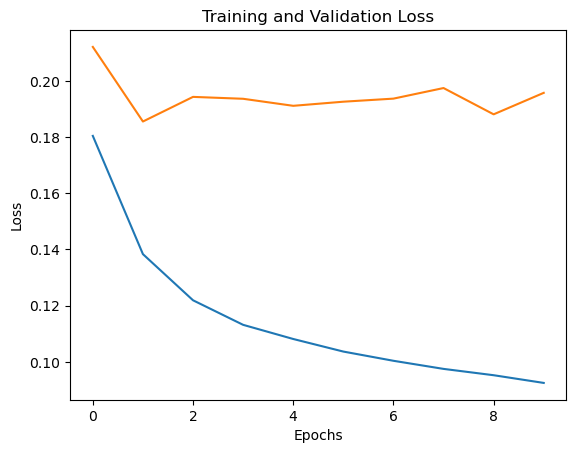

In [27]:
main()